# Important Note
When any code changes are made, please run each code block from top to bottom to ensure certain data structures are emptied and reloaded. 

# Required Modules
Here we will import all required modules for our project.

In [107]:
#also should install conda install nomkl...stops kernel from crashing on jupyter
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
from textblob import TextBlob
from numpy.random import seed

# Reproducible Results
To reproduce our results, we have set the seed for numpy's random number generator.

In [108]:
seed(1)

# Pre-processing Data
Here we will pre-process our tweet and stock data and extract features from the data. 

### Loading Files
Below we initalize the paths for our datasets as well as load them with the pandas module.

In [109]:
tweet_csv_name = '../datasets/tesla-tweets-18-1-1to18-11-27.csv'
stock_csv_name = '../datasets/tesla-stocks-18-1-1to18-11-27.csv'
tweet_dataset = pd.read_csv(tweet_csv_name)
stock_dataset = pd.read_csv(stock_csv_name)

### Processing Tweet Data
In this section, we will process |tweet_dataset| to obtain a list of lists, |tweet_data|. Each inner list will contain the average sentiment and average subjectivity of the tweets from a particular day, i.e. [avg_sentiment, avg_subjectivity]. In addition, each list in |tweet_data| corresponds to a particular day. That is, the 0th entry of |tweet_data| corresponds to 1/1/2018 and the last entry of |tweet_data| corresponds to 11/27/2018. In the end, the |tweet_data| should look like this:

[[avg_sentiment_0, avg_subjectivity_0] ==> (1/1/2018),
[avg_sentiment_1, avg_subjectivity_1] ==> (1/2/2018),
...,
[avg_sentiment_330, avg_subjectivity_330] ==> (11/27/2018)
]

This list should contain 331 entries. 

To calculate the avg_sentiment and avg_subjectivity for a day, we feed each tweet for a day into textblob to get each tweet's sentiment score and subjectivity score. We then weight each of these sentiment scores and subjectivity scores by the sum of a particular tweet's number of replies, number of retweets, and number of favorites. Lastly, we average these weighted sentiment scores and subjectivity scores by dividing by the total number of replies, retweets, and favorites in that day. That is, for a particular day,

avg_sentiment = ((#replies_tweet_0 + #retweets_tweet_0 + #favorites_tweet_0)*sentiment_tweet_0 + (#replies_tweet_1 + #retweets_tweet_1 + #favorites_tweet_1)*sentiment_tweet_1 + ... + (#replies_tweet_N + #retweets_tweet_N + #favorites_tweet_N)*sentiment_tweet_N)/(#replies_tweet_0 + #retweets_tweet_0 + #favorites_tweet_0 + #replies_tweet_1 + #retweets_tweet_1 + #favorites_tweet_1 + ... + #replies_tweet_N + #retweets_tweet_N + #favorites_tweet_N)

avg_subjectivity = ((#replies_tweet_0 + #retweets_tweet_0 + #favorites_tweet_0)*subjectivity_tweet_0 + (#replies_tweet_1 + #retweets_tweet_1 + #favorites_tweet_1)*subjectivity_tweet_1 + ... + (#replies_tweet_N + #retweets_tweet_N + #favorites_tweet_N)*subjectivity_tweet_N)/(#replies_tweet_0 + #retweets_tweet_0 + #favorites_tweet_0 + #replies_tweet_1 + #retweets_tweet_1 + #favorites_tweet_1 + ... + #replies_tweet_N + #retweets_tweet_N + #favorites_tweet_N)

where N is the number of tweets in a day. Note that sentiment for a tweet ranges from -1 to 1 inclusive, with -1 being negative sentiment and 1 being positive sentiment. Subjectivity for a particular tweet ranges from 0 to 1 inclusive, with 0 being complete objectivity and 1 being complete subjectivity.

Note, takes about 30 seconds to run.

In [110]:
print('Processing tweets dataset...')
def convert_to_int(input):
    '''
    A custom method to convert #replies, #retweets, #favorites to floats from |tweet_dataset|, since they come in the form
    float('nan'), #.#K, or #... for some odd reason.
    '''
    if not isinstance(input, str) and math.isnan(input):
        return 0
    if 'K' in input:
        return float(1000*float(input[:len(input) - 1]))
    return float(input)

tweet_data = [[]]
dates = tweet_dataset['published_date']
tweets = tweet_dataset['content']
replies = tweet_dataset['replies']
retweets = tweet_dataset['retweets']
favorites = tweet_dataset['favorites']

prev_date = dates[0].split()[0]

total_sentiment = 0
total_subjectivity = 0
total_weights = 0

for i in range(len(dates)):
    tweet = tweets[i]
    num_replies = convert_to_int(replies[i])
    num_retweets = convert_to_int(retweets[i])
    num_favorites = convert_to_int(favorites[i])
    
    tb = TextBlob(tweet)
    tweet_sentiment = tb.sentiment[0]
    tweet_subjectivity = tb.sentiment[1]
    
    tweet_sentiment *= (num_replies + num_retweets + num_favorites)
    tweet_subjectivity *= (num_replies + num_retweets + num_favorites)
    total_sentiment += tweet_sentiment
    total_subjectivity += tweet_subjectivity
    total_weights += (num_replies + num_retweets + num_favorites)
    
    curr_date = dates[i].split()[0]

    if curr_date != prev_date:
        tweet_data[len(tweet_data) - 1].append(total_sentiment/total_weights)
        tweet_data[len(tweet_data) - 1].append(total_subjectivity/total_weights)
        tweet_data.append([])
        prev_date = curr_date
        total_sentiment = 0
        total_subjectivity = 0
        total_weights = 0

tweet_data[len(tweet_data) - 1].append(total_sentiment/total_weights)
tweet_data[len(tweet_data) - 1].append(total_subjectivity/total_weights)

print("{} days worth of tweet data read (should be 331)...".format(len(tweet_data)))
print("Done!")

Processing tweets dataset...
331 days worth of tweet data read (should be 331)...
Done!


### Processing Stock Data
In this section we will process |stock_dataset| to obtain a list of stock prices, |stock_data|. Each element is the closing stock price for a particular date. Each element within |stock_data| also corresponds to a particular date, with the 0th element of |stock_data| corresponding to 1/1/18 and the last element corresponding to the 11/27/18. Note that the stock market is closed on holidays and weekends, therefore we will estimate missing stock prices via (x + y)/2, where x is the last known stock price, and y is the next available stock price. In the end, 331 days worth of stock data should have been processed.

Processing stocks dataset...
331 days worth of stock data read (should be 331)...


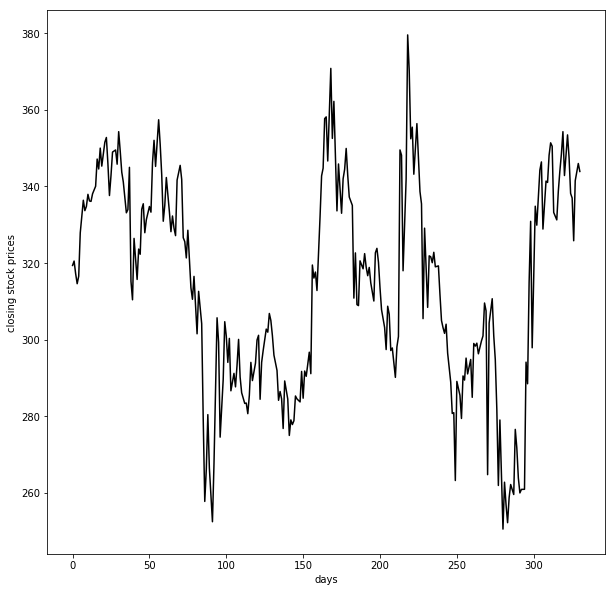

Done!


In [136]:
print("Processing stocks dataset...")
stock_data = []
dates = stock_dataset["Date"]
closing_stock_prices = stock_dataset["Close"]

one_day = timedelta(days=1)
year, month, day = dates[0].split("-")
year = int(year)
month = int(month)
day = int(day)
prev_date = date(year=year, month=month, day=day)
prev_stock_price = float(closing_stock_prices[0])

for i in range(1, len(dates)):
    year, month, day = dates[i].split('-')
    year = int(year)
    month = int(month)
    day = int(day)

    curr_date = date(year=year, month=month, day=day)
    curr_stock_price = float(closing_stock_prices[i])

    if curr_date - prev_date > one_day:
        prev_date += one_day
        while prev_date != curr_date:
            prev_stock_price = (prev_stock_price + curr_stock_price)/2
            stock_data.append(prev_stock_price)
            prev_date += one_day

    stock_data.append(curr_stock_price)
    prev_date = curr_date

#removes the entries for  12/30/17 and 12/31/17
stock_data.pop(0)
stock_data.pop(0)

print("{} days worth of stock data read (should be 331)...".format(len(stock_data)))

plt.plot([i for i in range(len(stock_data))], stock_data, 'black', label='actual')
plt.xlabel("days")
plt.ylabel("closing stock prices")
plt.show()
print("Done!")

### Combining Tweet and Stock Data
Here we will combine the tweet and stock data into a single dataset, |dataX|. Each element in |dataX| is a list of the form [avg_sentiment, avg_subjectivity, stock_price].

In [137]:
dataX = []
for i in range(len(tweet_data)):
    x = tweet_data[i] + [stock_data[i]]
    dataX.append(x)
print("{} entries in dataX (should be 331)...".format(len(dataX)))
print("Done!")

331 entries in dataX (should be 331)...
Done!


### Feature Extraction
Here we will declare methods to extract features from each day in |dataX| to create |dataPHI|, where each element of |dataPHI| is a list and each list is the featurized version of the corresponding list in |dataX|. Create features here and describe them. Append them to |features| in the order they were created. We will also standardize the entries in |dataPHI|.

Note, we commented out features that did not seem correlated with the output. 

In [114]:
features = []
feature_names = []

def compute_phi(x):
    '''
    Computes the feature vector |phi| from the datapoint |x| and returns it.
    '''
    phi = []
    for phi_i in features:
        phi.append(phi_i(x))
    return phi

#feature_names.append("avg_sentiment")
def avg_sentiment(x):
    return x[0]
#features.append(avg_sentiment)

feature_names.append("avg_subjectivity")
def avg_subjectivity(x):
    return x[1]
features.append(avg_subjectivity)

feature_names.append("stock_price")
def stock_price(x):
    return x[2]
features.append(stock_price)

#feature_names.append("avg_sentiment_and_avg_subjectivity")
# def avg_sentiment_and_subjectivity_price(x):
#     return avg_sentiment(x) * avg_subjectivity(x)
#features.append(avg_sentiment_and_subjectivity_price)

# feature_names.append("avg_sentiment_and_stock_price")
# def avg_sentiment_and_stock_price(x):
#     return avg_sentiment(x) * stock_price(x)
# features.append(avg_sentiment_and_stock_price)

feature_names.append("avg_subjectivity_and_stock_price")
def avg_subjectivity_and_stock_price(x):
    return avg_subjectivity(x) * stock_price(x)
features.append(avg_subjectivity_and_stock_price)

dataPHI = []
for x in dataX:
    phi = compute_phi(x)
    dataPHI.append(phi)

dataPHI = preprocessing.scale(dataPHI)
print("{} features added...".format(len(features)))
print("Features are named: ")
for i, feature_name in enumerate(feature_names): print("%d."%i, feature_name)
print("{} entries in dataPHI (should be 331)...".format(len(dataPHI)))

3 features added...
Features are named: 
0. avg_subjectivity
1. stock_price
2. avg_subjectivity_and_stock_price
331 entries in dataPHI (should be 331)...


### Infrastructure for AR Model with Memory M
Here we will build the infrastructure for an AR model with memory |M|. To do this, we will create |timeseries_dataPHI| and |dataY|. |timeseries_dataPHI| is a numpy array. Each entry of |timeseries_dataPHI| holds |M| consecutive datapoints from dataPHI, i.e. we'll be using a sliding window. |dataY| is also a numpy array. Each entry of |dataY| holds the datapoint that comes immediately after the size |M| window for the corresponding entry in |timeseries_dataPHI|.

In [138]:
M = 11 #set the value of M here

timeseries_dataPHI = []

print("Consolidating tweet and stock datasets w memory M = {}...".format(M))
for i in range(len(dataPHI) - M):
    x = [dataPHI[j] for j in range(i, i + M)]
    timeseries_dataPHI.append(x)

dataY = []
for i in range(len(tweet_data) - M):
    y = stock_data[i + M]
    dataY.append(y)
    
timeseries_dataPHI = np.array(timeseries_dataPHI)
dataY = np.array(dataY)
print("{} entries in timeseries_dataPHI (should be 331 - M)...".format(len(timeseries_dataPHI)))
print("{} entries in dataY (should be 331 - M)...".format(len(dataY)))

Consolidating tweet and stock datasets w memory M = 11...
320 entries in timeseries_dataPHI (should be 331 - M)...
320 entries in dataY (should be 331 - M)...


### Splitting Data into Train and Test Sets
Next, we will want to split our data into a training set and test set in order to cross-validate and tune hyperparameters. From |timeseries_dataPHI| and |dataY|, we will allocate the latter |TEST_SIZE|x100% of it to be the test set. Then, we will allocate the former |TRAIN_SIZE|x100% to be the train set. From the train set, we will conduct validation to determine the generality of our models later on.

In [116]:
TRAIN_SIZE = 0.8 #set train set size here
TEST_SIZE = 1 - TRAIN_SIZE #test set size derived from train set size

print("Splitting data into train ({}%) and test ({}%) sets...".format(TRAIN_SIZE*100, TEST_SIZE*100))
timeseries_dataPHI_train, timeseries_dataPHI_test, dataY_train, dataY_test = train_test_split(timeseries_dataPHI, dataY, test_size=TEST_SIZE, random_state=0, shuffle=False)
print("Total number of datapoints is {}.".format(len(timeseries_dataPHI)))
print("Train set has {} datapoints.".format(len(timeseries_dataPHI_train)))
print("Test set has {} datapoints.".format(len(timeseries_dataPHI_test)))

Splitting data into train (80.0%) and test (19.999999999999996%) sets...
Total number of datapoints is 320.
Train set has 256 datapoints.
Test set has 64 datapoints.


# Determining the Relevance of Features
Here we determine the relevance of each of our features in two ways. First, features with low variance are unlikely to contribute anything to the output. Second, by measuring their correlation with the output data. This helps us to determine which features are relevant. When correlation is close to 1 or -1, it means features are very linearly correlated. When correlation is close to 0, it may not necessarily mean features are not correlated with the output data. It means features are not linearly correlated with the output data. Keep this in mind when deleting, adding, or modifying features, as these features may be important when using a neural network model, as neural nets can determine non-linear relationships between features and outputs.

In [117]:
print("These are the variances for each of the features...")
phi_var = np.var(timeseries_dataPHI_train.reshape(len(timeseries_dataPHI_train), M*len(features)), axis=0)
print("Matrix has shape {}... Should be of shape ({},)...".format(phi_var.shape, M*len(features)))
print(phi_var)
print("\n")

print("This is the covariance matrix for the features...")
z = timeseries_dataPHI_train.reshape(len(timeseries_dataPHI_train), M*len(features))
phi_cov_matrix = np.cov(z, rowvar=False)
print("Matrix has shape {}... Should be of shape ({}, {})...".format(phi_cov_matrix.shape, M*len(features), M*len(features)))
print(phi_cov_matrix)
print("\n")

print("This is the covariance matrix for the features and stock values...")
z = np.append(
        z, 
        dataY_train.reshape(len(dataY_train), 1),
        axis=1
)
phi_and_stock_cov_matrix = np.cov(z, rowvar=False)
print("Matrix has shape {}... Should be of shape({}, {})...".format(phi_and_stock_cov_matrix.shape, M*len(features) + 1, M*len(features) + 1))
print(phi_and_stock_cov_matrix)
print("\n")

print("This is the correlation matrix for the features and stock values...")
phi_and_stock_corr_matrix = np.corrcoef(z, rowvar=False)
print("Matrix has shape {}... Should be of shape ({}, {})...".format(phi_and_stock_corr_matrix.shape, M*len(features) + 1, M*len(features) + 1))
print(phi_and_stock_corr_matrix)
print("\n")

print("These are the correlations between our features and stock values...")
corr_feature_stock = phi_and_stock_corr_matrix[:,M*len(features)][:-1]
print("Matrix has shape {}... Should be of shape ({},)...".format(corr_feature_stock.shape, M*len(features)))
print(corr_feature_stock)
print("\n")

These are the variances for each of the features...
Matrix has shape (33,)... Should be of shape (33,)...
[0.99298502 0.8542712  0.976218   0.98821835 0.85654281 0.97162464
 0.99224659 0.85973574 0.96908987 0.99525268 0.86251944 0.97044244
 0.9723808  0.86484525 0.9494857  0.97244927 0.86983723 0.95014745
 0.98180597 0.87053581 0.95668937 0.98266049 0.87068115 0.95806129
 0.97951985 0.86980844 0.95665961 0.9849618  0.86995055 0.96100463
 0.98570298 0.86949877 0.96038   ]


This is the covariance matrix for the features...
Matrix has shape (33, 33)... Should be of shape (33, 33)...
[[ 0.99687908 -0.1058962   0.95886446 ... -0.07250667 -0.02382927
  -0.07716579]
 [-0.1058962   0.85762128  0.10702436 ... -0.15283498  0.45776118
  -0.04175812]
 [ 0.95886446  0.10702436  0.98004631 ... -0.10677783  0.08799137
  -0.08483159]
 ...
 [-0.07250667 -0.15283498 -0.10677783 ...  0.98956848 -0.11242391
   0.94649915]
 [-0.02382927  0.45776118  0.08799137 ... -0.11242391  0.87290857
   0.10474831]
 [

# Building, Validating, and Testing Models
Here we will build the models for our project. In addition, we will perform validation and testing on our models. 

### Linear Regression
Our first model to build is linear regression.

#### Hyperparameters (lr)
Below is a set of hyperparameters to tune for the linear regression model.

In [118]:
LR_BATCH_SIZE = 15
LR_EPOCHS = 300
LR_OPTIMIZER = SGD(lr=0.08)
LR_LOSS = "mean_squared_error"

#### Validation (lr)
Since our data contains time series, we will use forward chaining/nested cross-validation to validate our model. Our goal is to make average validation error small by tuning hyperparameters and modifying features. Then we can go on to train our model on the entire training set.

Note, takes about 3 minutes to run. 

In [119]:
NUM_SPLITS = 5 #change splits here
tss = TimeSeriesSplit(NUM_SPLITS)

lr_avg_val_err = 0
for subtrain_indices, val_indices in tss.split(timeseries_dataPHI_train):
    subtrain_dataPHI = timeseries_dataPHI_train[subtrain_indices[0]:subtrain_indices[len(subtrain_indices) - 1]]
    subtrain_dataY = dataY_train[subtrain_indices[0]:subtrain_indices[len(subtrain_indices) - 1]]
    val_dataPHI = timeseries_dataPHI_train[val_indices[0]:val_indices[len(val_indices) - 1]]
    val_dataY = dataY_train[val_indices[0]:val_indices[len(val_indices) - 1]]
    lr = Sequential()
    lr.add(Dense(units=1, activation='linear', input_dim=M * len(features)))
    lr.compile(loss=LR_LOSS, optimizer=LR_OPTIMIZER)
    lr.fit(x=subtrain_dataPHI.reshape(len(subtrain_dataPHI), M * len(features)), y=subtrain_dataY, batch_size=LR_BATCH_SIZE, epochs=LR_EPOCHS, verbose=1)
    
    val_pred_stocks = lr.predict(val_dataPHI.reshape(len(val_dataPHI), M * len(features)))[:,0]
    val_actual_stocks = val_dataY
    lr_avg_val_err += math.sqrt(mean_squared_error(val_pred_stocks, val_actual_stocks))
    
lr_avg_val_err /= NUM_SPLITS
print("The average validation error for linear regression is {}".format(lr_avg_val_err))

Epoch 1/300
45/45 [==============================] - 4s 94ms/step - loss: 53034.9645
Epoch 2/300
45/45 [==============================] - 0s 119us/step - loss: 10002.5023
Epoch 3/300
45/45 [==============================] - 0s 119us/step - loss: 7359.5711
Epoch 4/300
45/45 [==============================] - 0s 125us/step - loss: 5951.7788
Epoch 5/300
45/45 [==============================] - 0s 116us/step - loss: 5644.6178
Epoch 6/300
45/45 [==============================] - 0s 124us/step - loss: 6122.4006
Epoch 7/300
45/45 [==============================] - 0s 121us/step - loss: 6138.4258
Epoch 8/300
45/45 [==============================] - 0s 113us/step - loss: 4493.7082
Epoch 9/300
45/45 [==============================] - 0s 138us/step - loss: 3428.4832
Epoch 10/300
45/45 [==============================] - 0s 120us/step - loss: 3310.0138
Epoch 11/300
45/45 [==============================] - 0s 115us/step - loss: 3361.0876
Epoch 12/300
45/45 [==============================] - 0s 131us

45/45 [==============================] - 0s 126us/step - loss: 146.2827
Epoch 98/300
45/45 [==============================] - 0s 122us/step - loss: 107.5324
Epoch 99/300
45/45 [==============================] - 0s 120us/step - loss: 140.3269
Epoch 100/300
45/45 [==============================] - 0s 114us/step - loss: 130.1465
Epoch 101/300
45/45 [==============================] - 0s 119us/step - loss: 100.5612
Epoch 102/300
45/45 [==============================] - 0s 128us/step - loss: 106.9356
Epoch 103/300
45/45 [==============================] - 0s 119us/step - loss: 94.2793
Epoch 104/300
45/45 [==============================] - 0s 112us/step - loss: 142.5223
Epoch 105/300
45/45 [==============================] - 0s 138us/step - loss: 104.3131
Epoch 106/300
45/45 [==============================] - 0s 117us/step - loss: 118.1099
Epoch 107/300
45/45 [==============================] - 0s 128us/step - loss: 119.0242
Epoch 108/300
45/45 [==============================] - 0s 116us/step - 

45/45 [==============================] - 0s 113us/step - loss: 54.7990
Epoch 194/300
45/45 [==============================] - 0s 112us/step - loss: 101.8815
Epoch 195/300
45/45 [==============================] - 0s 136us/step - loss: 46.2715
Epoch 196/300
45/45 [==============================] - 0s 118us/step - loss: 46.9123
Epoch 197/300
45/45 [==============================] - 0s 110us/step - loss: 46.0953
Epoch 198/300
45/45 [==============================] - 0s 118us/step - loss: 39.3100
Epoch 199/300
45/45 [==============================] - 0s 113us/step - loss: 46.4380
Epoch 200/300
45/45 [==============================] - 0s 131us/step - loss: 39.8966
Epoch 201/300
45/45 [==============================] - 0s 119us/step - loss: 43.6186
Epoch 202/300
45/45 [==============================] - 0s 115us/step - loss: 119.5405
Epoch 203/300
45/45 [==============================] - 0s 119us/step - loss: 56.0268
Epoch 204/300
45/45 [==============================] - 0s 114us/step - loss: 

45/45 [==============================] - 0s 114us/step - loss: 32.6318
Epoch 290/300
45/45 [==============================] - 0s 139us/step - loss: 32.9448
Epoch 291/300
45/45 [==============================] - 0s 129us/step - loss: 36.7331
Epoch 292/300
45/45 [==============================] - 0s 121us/step - loss: 42.8112
Epoch 293/300
45/45 [==============================] - 0s 124us/step - loss: 56.6922
Epoch 294/300
45/45 [==============================] - 0s 142us/step - loss: 64.5799
Epoch 295/300
45/45 [==============================] - 0s 123us/step - loss: 38.9028
Epoch 296/300
45/45 [==============================] - 0s 125us/step - loss: 34.0336
Epoch 297/300
45/45 [==============================] - 0s 115us/step - loss: 33.7849
Epoch 298/300
45/45 [==============================] - 0s 112us/step - loss: 35.3660
Epoch 299/300
45/45 [==============================] - 0s 100us/step - loss: 32.9937
Epoch 300/300
45/45 [==============================] - 0s 102us/step - loss: 38

87/87 [==============================] - 0s 110us/step - loss: 123.1154
Epoch 87/300
87/87 [==============================] - 0s 110us/step - loss: 86.3564
Epoch 88/300
87/87 [==============================] - 0s 116us/step - loss: 92.1137
Epoch 89/300
87/87 [==============================] - 0s 112us/step - loss: 74.8301
Epoch 90/300
87/87 [==============================] - 0s 136us/step - loss: 131.1579
Epoch 91/300
87/87 [==============================] - 0s 113us/step - loss: 73.8480
Epoch 92/300
87/87 [==============================] - 0s 110us/step - loss: 80.1696
Epoch 93/300
87/87 [==============================] - 0s 117us/step - loss: 75.0586
Epoch 94/300
87/87 [==============================] - 0s 124us/step - loss: 80.0254
Epoch 95/300
87/87 [==============================] - 0s 117us/step - loss: 69.3350
Epoch 96/300
87/87 [==============================] - 0s 118us/step - loss: 77.3949
Epoch 97/300
87/87 [==============================] - 0s 121us/step - loss: 87.5303
Epo

87/87 [==============================] - 0s 103us/step - loss: 106.2180
Epoch 183/300
87/87 [==============================] - 0s 116us/step - loss: 80.9804
Epoch 184/300
87/87 [==============================] - 0s 109us/step - loss: 75.8879
Epoch 185/300
87/87 [==============================] - 0s 108us/step - loss: 66.6467
Epoch 186/300
87/87 [==============================] - 0s 110us/step - loss: 70.4017
Epoch 187/300
87/87 [==============================] - 0s 101us/step - loss: 97.3761
Epoch 188/300
87/87 [==============================] - 0s 109us/step - loss: 62.5594
Epoch 189/300
87/87 [==============================] - 0s 107us/step - loss: 71.7740
Epoch 190/300
87/87 [==============================] - 0s 101us/step - loss: 94.7900
Epoch 191/300
87/87 [==============================] - 0s 105us/step - loss: 63.8258
Epoch 192/300
87/87 [==============================] - 0s 109us/step - loss: 65.5307
Epoch 193/300
87/87 [==============================] - 0s 107us/step - loss: 7

87/87 [==============================] - 0s 107us/step - loss: 64.9968
Epoch 279/300
87/87 [==============================] - 0s 114us/step - loss: 73.1479
Epoch 280/300
87/87 [==============================] - 0s 104us/step - loss: 93.9759
Epoch 281/300
87/87 [==============================] - 0s 108us/step - loss: 74.7613
Epoch 282/300
87/87 [==============================] - 0s 102us/step - loss: 87.4896
Epoch 283/300
87/87 [==============================] - 0s 104us/step - loss: 87.7074
Epoch 284/300
87/87 [==============================] - 0s 101us/step - loss: 68.4956
Epoch 285/300
87/87 [==============================] - 0s 98us/step - loss: 60.6604
Epoch 286/300
87/87 [==============================] - 0s 114us/step - loss: 103.1386
Epoch 287/300
87/87 [==============================] - 0s 110us/step - loss: 105.1149
Epoch 288/300
87/87 [==============================] - 0s 103us/step - loss: 72.0904
Epoch 289/300
87/87 [==============================] - 0s 110us/step - loss: 7

129/129 [==============================] - 0s 97us/step - loss: 83.1703
Epoch 74/300
129/129 [==============================] - 0s 99us/step - loss: 80.6768
Epoch 75/300
129/129 [==============================] - 0s 98us/step - loss: 81.4738
Epoch 76/300
129/129 [==============================] - 0s 100us/step - loss: 72.1564
Epoch 77/300
129/129 [==============================] - 0s 98us/step - loss: 77.0678
Epoch 78/300
129/129 [==============================] - 0s 100us/step - loss: 108.2456
Epoch 79/300
129/129 [==============================] - 0s 99us/step - loss: 72.5780
Epoch 80/300
129/129 [==============================] - 0s 99us/step - loss: 75.5959
Epoch 81/300
129/129 [==============================] - 0s 105us/step - loss: 74.9064
Epoch 82/300
129/129 [==============================] - 0s 101us/step - loss: 80.8518
Epoch 83/300
129/129 [==============================] - 0s 101us/step - loss: 89.2046
Epoch 84/300
129/129 [==============================] - 0s 99us/step - l

129/129 [==============================] - 0s 99us/step - loss: 77.7688
Epoch 168/300
129/129 [==============================] - 0s 99us/step - loss: 64.6798
Epoch 169/300
129/129 [==============================] - 0s 100us/step - loss: 81.2648
Epoch 170/300
129/129 [==============================] - 0s 100us/step - loss: 69.1725
Epoch 171/300
129/129 [==============================] - 0s 99us/step - loss: 58.8626
Epoch 172/300
129/129 [==============================] - 0s 103us/step - loss: 69.4927
Epoch 173/300
129/129 [==============================] - 0s 104us/step - loss: 66.5975
Epoch 174/300
129/129 [==============================] - 0s 101us/step - loss: 72.8233
Epoch 175/300
129/129 [==============================] - 0s 102us/step - loss: 72.1887
Epoch 176/300
129/129 [==============================] - 0s 102us/step - loss: 77.2205
Epoch 177/300
129/129 [==============================] - 0s 112us/step - loss: 66.7294
Epoch 178/300
129/129 [==============================] - 0s 

129/129 [==============================] - 0s 101us/step - loss: 71.4759
Epoch 262/300
129/129 [==============================] - 0s 97us/step - loss: 66.3786
Epoch 263/300
129/129 [==============================] - 0s 100us/step - loss: 66.2888
Epoch 264/300
129/129 [==============================] - 0s 99us/step - loss: 68.6076
Epoch 265/300
129/129 [==============================] - 0s 101us/step - loss: 75.0386
Epoch 266/300
129/129 [==============================] - 0s 102us/step - loss: 73.8414
Epoch 267/300
129/129 [==============================] - 0s 101us/step - loss: 85.3733
Epoch 268/300
129/129 [==============================] - 0s 105us/step - loss: 81.0124
Epoch 269/300
129/129 [==============================] - 0s 100us/step - loss: 72.6971
Epoch 270/300
129/129 [==============================] - 0s 104us/step - loss: 76.8412
Epoch 271/300
129/129 [==============================] - 0s 103us/step - loss: 69.0103
Epoch 272/300
129/129 [==============================] - 0s

171/171 [==============================] - 0s 97us/step - loss: 92.9767
Epoch 56/300
171/171 [==============================] - 0s 98us/step - loss: 114.8538
Epoch 57/300
171/171 [==============================] - 0s 96us/step - loss: 111.1508
Epoch 58/300
171/171 [==============================] - 0s 103us/step - loss: 83.0008
Epoch 59/300
171/171 [==============================] - 0s 101us/step - loss: 91.4262
Epoch 60/300
171/171 [==============================] - 0s 101us/step - loss: 101.2377
Epoch 61/300
171/171 [==============================] - 0s 97us/step - loss: 85.6402
Epoch 62/300
171/171 [==============================] - 0s 105us/step - loss: 122.8279
Epoch 63/300
171/171 [==============================] - 0s 101us/step - loss: 85.4065
Epoch 64/300
171/171 [==============================] - 0s 100us/step - loss: 89.9584
Epoch 65/300
171/171 [==============================] - 0s 100us/step - loss: 117.5427
Epoch 66/300
171/171 [==============================] - 0s 102us/s

171/171 [==============================] - 0s 100us/step - loss: 78.3296
Epoch 150/300
171/171 [==============================] - 0s 99us/step - loss: 95.3658
Epoch 151/300
171/171 [==============================] - 0s 102us/step - loss: 126.7490
Epoch 152/300
171/171 [==============================] - 0s 99us/step - loss: 95.3559
Epoch 153/300
171/171 [==============================] - 0s 104us/step - loss: 80.4898
Epoch 154/300
171/171 [==============================] - 0s 100us/step - loss: 107.7579
Epoch 155/300
171/171 [==============================] - 0s 102us/step - loss: 86.3414
Epoch 156/300
171/171 [==============================] - 0s 103us/step - loss: 86.9144
Epoch 157/300
171/171 [==============================] - 0s 100us/step - loss: 97.3570
Epoch 158/300
171/171 [==============================] - 0s 103us/step - loss: 105.7874
Epoch 159/300
171/171 [==============================] - 0s 100us/step - loss: 119.0973
Epoch 160/300
171/171 [==============================] 

171/171 [==============================] - 0s 98us/step - loss: 120.6013
Epoch 244/300
171/171 [==============================] - 0s 96us/step - loss: 72.3097
Epoch 245/300
171/171 [==============================] - 0s 95us/step - loss: 138.9640
Epoch 246/300
171/171 [==============================] - 0s 93us/step - loss: 141.8585
Epoch 247/300
171/171 [==============================] - 0s 94us/step - loss: 100.3450
Epoch 248/300
171/171 [==============================] - 0s 104us/step - loss: 133.6633
Epoch 249/300
171/171 [==============================] - 0s 97us/step - loss: 111.9973
Epoch 250/300
171/171 [==============================] - 0s 96us/step - loss: 96.4451
Epoch 251/300
171/171 [==============================] - 0s 99us/step - loss: 110.2324
Epoch 252/300
171/171 [==============================] - 0s 100us/step - loss: 90.1654
Epoch 253/300
171/171 [==============================] - 0s 100us/step - loss: 82.5516
Epoch 254/300
171/171 [==============================] - 0

213/213 [==============================] - 0s 97us/step - loss: 122.8310
Epoch 38/300
213/213 [==============================] - 0s 98us/step - loss: 142.5020
Epoch 39/300
213/213 [==============================] - 0s 98us/step - loss: 154.6633
Epoch 40/300
213/213 [==============================] - 0s 99us/step - loss: 130.4239
Epoch 41/300
213/213 [==============================] - 0s 103us/step - loss: 103.2516
Epoch 42/300
213/213 [==============================] - 0s 105us/step - loss: 155.9617
Epoch 43/300
213/213 [==============================] - 0s 102us/step - loss: 125.9277
Epoch 44/300
213/213 [==============================] - 0s 100us/step - loss: 102.1552
Epoch 45/300
213/213 [==============================] - 0s 104us/step - loss: 124.9970
Epoch 46/300
213/213 [==============================] - 0s 101us/step - loss: 115.9148
Epoch 47/300
213/213 [==============================] - 0s 100us/step - loss: 95.9493
Epoch 48/300
213/213 [==============================] - 0s 99

213/213 [==============================] - 0s 101us/step - loss: 110.9213
Epoch 132/300
213/213 [==============================] - 0s 104us/step - loss: 112.7818
Epoch 133/300
213/213 [==============================] - 0s 104us/step - loss: 112.1142
Epoch 134/300
213/213 [==============================] - 0s 100us/step - loss: 111.4883
Epoch 135/300
213/213 [==============================] - 0s 100us/step - loss: 113.7502
Epoch 136/300
213/213 [==============================] - 0s 100us/step - loss: 119.5312
Epoch 137/300
213/213 [==============================] - 0s 97us/step - loss: 112.4514
Epoch 138/300
213/213 [==============================] - 0s 96us/step - loss: 108.0462
Epoch 139/300
213/213 [==============================] - 0s 97us/step - loss: 101.5929
Epoch 140/300
213/213 [==============================] - 0s 96us/step - loss: 141.2170
Epoch 141/300
213/213 [==============================] - 0s 94us/step - loss: 181.7521
Epoch 142/300
213/213 [============================

213/213 [==============================] - 0s 102us/step - loss: 108.7244
Epoch 225/300
213/213 [==============================] - 0s 98us/step - loss: 137.3469
Epoch 226/300
213/213 [==============================] - 0s 100us/step - loss: 97.6946
Epoch 227/300
213/213 [==============================] - 0s 100us/step - loss: 104.5483
Epoch 228/300
213/213 [==============================] - 0s 102us/step - loss: 100.7447
Epoch 229/300
213/213 [==============================] - 0s 98us/step - loss: 102.5158
Epoch 230/300
213/213 [==============================] - 0s 100us/step - loss: 114.4357
Epoch 231/300
213/213 [==============================] - 0s 94us/step - loss: 144.1257
Epoch 232/300
213/213 [==============================] - 0s 98us/step - loss: 102.7919
Epoch 233/300
213/213 [==============================] - 0s 94us/step - loss: 101.9732
Epoch 234/300
213/213 [==============================] - 0s 104us/step - loss: 102.2788
Epoch 235/300
213/213 [=============================

#### Implementation/Training on Entire Train Set (lr)
Now that we have tuned our hyperparameters, we will train on the entire training set. 

In [120]:
lr = Sequential()
lr.add(Dense(units=1, activation='linear', input_dim=M * len(features)))
lr.compile(loss=LR_LOSS, optimizer=LR_OPTIMIZER)
lr.fit(x=timeseries_dataPHI_train.reshape(len(timeseries_dataPHI_train), M * len(features)), y=dataY_train, batch_size=LR_BATCH_SIZE, epochs=LR_EPOCHS, verbose=1)

Epoch 1/300
256/256 [==============================] - 4s 16ms/step - loss: 26210.4042
Epoch 2/300
256/256 [==============================] - 0s 92us/step - loss: 413.1451
Epoch 3/300
256/256 [==============================] - 0s 98us/step - loss: 423.0289
Epoch 4/300
256/256 [==============================] - 0s 94us/step - loss: 193.2949
Epoch 5/300
256/256 [==============================] - 0s 95us/step - loss: 139.4475
Epoch 6/300
256/256 [==============================] - 0s 94us/step - loss: 122.3297
Epoch 7/300
256/256 [==============================] - 0s 95us/step - loss: 103.6658
Epoch 8/300
256/256 [==============================] - 0s 94us/step - loss: 127.3433
Epoch 9/300
256/256 [==============================] - 0s 96us/step - loss: 104.2722
Epoch 10/300
256/256 [==============================] - 0s 92us/step - loss: 159.0437
Epoch 11/300
256/256 [==============================] - 0s 99us/step - loss: 160.3826
Epoch 12/300
256/256 [==============================] - 0s 94

256/256 [==============================] - 0s 99us/step - loss: 132.1285
Epoch 97/300
256/256 [==============================] - 0s 95us/step - loss: 109.4641
Epoch 98/300
256/256 [==============================] - 0s 93us/step - loss: 123.2826
Epoch 99/300
256/256 [==============================] - 0s 97us/step - loss: 97.0131
Epoch 100/300
256/256 [==============================] - 0s 96us/step - loss: 103.3382
Epoch 101/300
256/256 [==============================] - 0s 99us/step - loss: 130.0728
Epoch 102/300
256/256 [==============================] - 0s 93us/step - loss: 100.1418
Epoch 103/300
256/256 [==============================] - 0s 98us/step - loss: 167.6024
Epoch 104/300
256/256 [==============================] - 0s 96us/step - loss: 117.1996
Epoch 105/300
256/256 [==============================] - 0s 100us/step - loss: 122.1230
Epoch 106/300
256/256 [==============================] - 0s 94us/step - loss: 308.6385
Epoch 107/300
256/256 [==============================] - 0s 

256/256 [==============================] - 0s 96us/step - loss: 229.7050
Epoch 191/300
256/256 [==============================] - 0s 95us/step - loss: 111.2993
Epoch 192/300
256/256 [==============================] - 0s 101us/step - loss: 132.1699
Epoch 193/300
256/256 [==============================] - 0s 101us/step - loss: 99.3262
Epoch 194/300
256/256 [==============================] - 0s 101us/step - loss: 222.3277
Epoch 195/300
256/256 [==============================] - 0s 102us/step - loss: 117.9834
Epoch 196/300
256/256 [==============================] - 0s 100us/step - loss: 122.4341
Epoch 197/300
256/256 [==============================] - 0s 102us/step - loss: 110.1410
Epoch 198/300
256/256 [==============================] - 0s 101us/step - loss: 102.6352
Epoch 199/300
256/256 [==============================] - 0s 98us/step - loss: 117.1580
Epoch 200/300
256/256 [==============================] - 0s 102us/step - loss: 103.7831
Epoch 201/300
256/256 [===========================

256/256 [==============================] - 0s 98us/step - loss: 114.1444
Epoch 285/300
256/256 [==============================] - 0s 97us/step - loss: 138.7357
Epoch 286/300
256/256 [==============================] - 0s 98us/step - loss: 134.7947
Epoch 287/300
256/256 [==============================] - 0s 101us/step - loss: 116.4569
Epoch 288/300
256/256 [==============================] - 0s 95us/step - loss: 101.1643
Epoch 289/300
256/256 [==============================] - 0s 104us/step - loss: 94.5501
Epoch 290/300
256/256 [==============================] - 0s 93us/step - loss: 141.8889
Epoch 291/300
256/256 [==============================] - 0s 105us/step - loss: 463.3963
Epoch 292/300
256/256 [==============================] - 0s 100us/step - loss: 192.9807
Epoch 293/300
256/256 [==============================] - 0s 94us/step - loss: 131.1397
Epoch 294/300
256/256 [==============================] - 0s 100us/step - loss: 587.8074
Epoch 295/300
256/256 [==============================

#### Error Analysis (lr)
Below we will conduct some error analysis on our model. We will compare average training errors and average test errors to see if our model is generalized. 

In [121]:
train_actual_stocks = dataY_train
test_actual_stocks = dataY_test

lr_train_pred_stocks = lr.predict(timeseries_dataPHI_train.reshape(len(timeseries_dataPHI_train), M * len(features)))[:,0]

lr_test_pred_stocks = lr.predict(timeseries_dataPHI_test.reshape(len(timeseries_dataPHI_test), M * len(features)))[:,0]
    
lr_avg_train_err = math.sqrt(mean_squared_error(lr_train_pred_stocks, train_actual_stocks))
lr_avg_test_err = math.sqrt(mean_squared_error(lr_test_pred_stocks, test_actual_stocks))

print("Average train error for linear regression was {}.".format(lr_avg_train_err))
print("Average test error for linear regression was {}.".format(lr_avg_test_err))

Average train error for linear regression was 11.316067062356819.
Average test error for linear regression was 17.391522015068396.


In [122]:
lr_train_accuracy = 0
for i in range(1, len(train_actual_stocks)):
    if((lr_train_pred_stocks[i] > train_actual_stocks[i-1] and train_actual_stocks[i] > train_actual_stocks[i-1]) or
       (lr_train_pred_stocks[i] < train_actual_stocks[i-1] and train_actual_stocks[i] < train_actual_stocks[i-1])
      ):
        lr_train_accuracy += 1
lr_train_accuracy /= len(train_actual_stocks)

lr_test_accuracy = 0
for i in range(1, len(test_actual_stocks)):
    if((lr_test_pred_stocks[i] > test_actual_stocks[i-1] and test_actual_stocks[i] > test_actual_stocks[i-1]) or
       (lr_test_pred_stocks[i] < test_actual_stocks[i-1] and test_actual_stocks[i] < test_actual_stocks[i-1])
      ):
        lr_test_accuracy += 1
lr_test_accuracy /= len(test_actual_stocks)

print("Average trend train accuracy for linear regression was {}.".format(lr_train_accuracy))
print("Average trend test accuracy for linear regression was {}.".format(lr_test_accuracy))

Average trend train accuracy for linear regression was 0.53515625.
Average trend test accuracy for linear regression was 0.453125.


#### Graphing Results (lr)
We will now graph our results for both our training and testing data. Ideally we would like all our predictions to fall on the blue line. 

[]

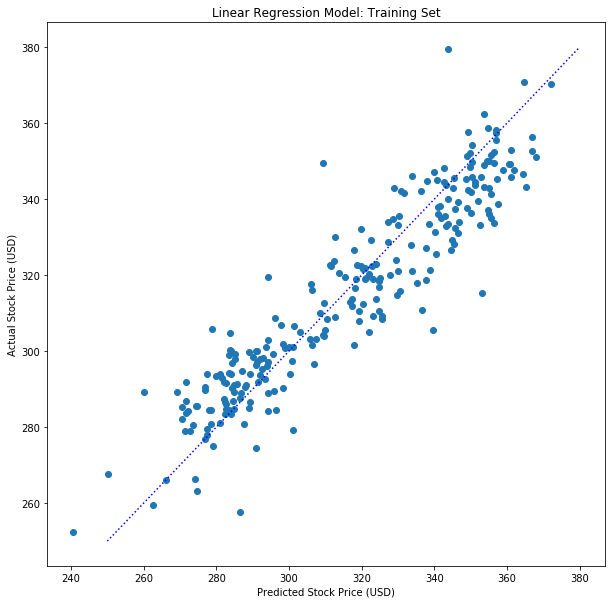

In [123]:
plt.scatter(lr_train_pred_stocks, train_actual_stocks)
plt.plot([250, 380], [250, 380], color='b', linestyle=':')
plt.title('Linear Regression Model: Training Set')
plt.xlabel('Predicted Stock Price (USD)')
plt.ylabel('Actual Stock Price (USD)')
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot()

[]

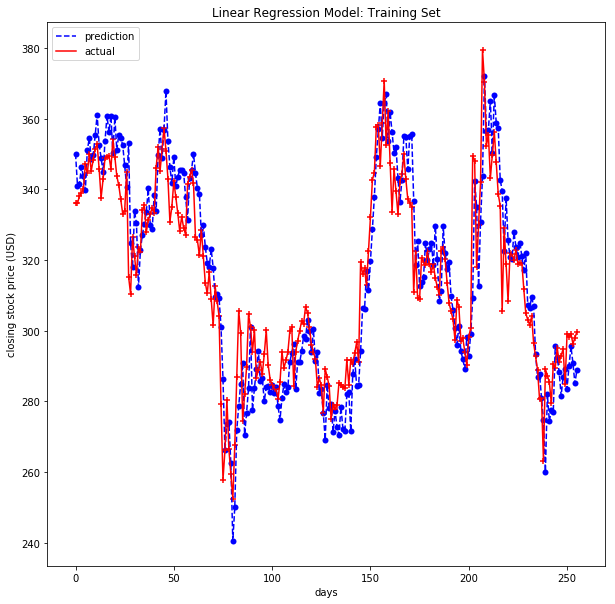

In [124]:
plt.scatter([i for i in range(len(lr_train_pred_stocks))], lr_train_pred_stocks, color='b', marker='o', linewidth=0)
plt.scatter([i for i in range(len(train_actual_stocks))], train_actual_stocks, color='r', marker='+')
plt.plot([i for i in range(len(lr_train_pred_stocks))], lr_train_pred_stocks, color='b', linestyle='--', label='prediction')
plt.plot([i for i in range(len(train_actual_stocks))], train_actual_stocks, color='r', linestyle='-', label='actual')

plt.legend(loc='upper left')
plt.title('Linear Regression Model: Training Set')
plt.xlabel('days')
plt.ylabel('closing stock price (USD)')
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot()

[]

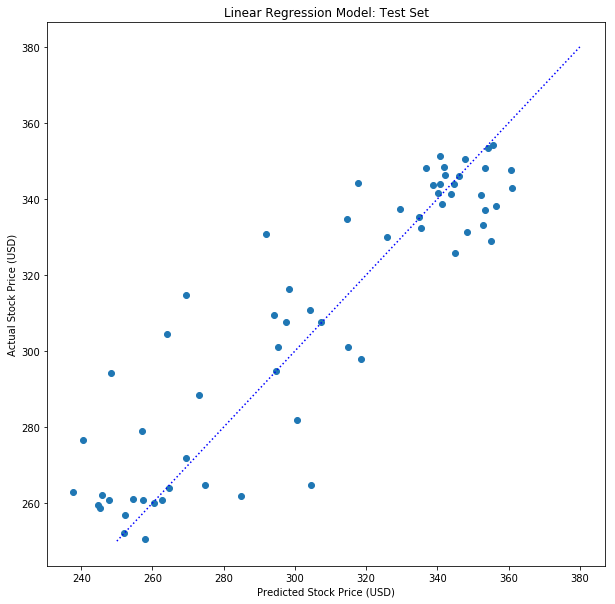

In [125]:
plt.scatter(lr_test_pred_stocks, test_actual_stocks)
plt.plot([250, 380], [250, 380], color='b', linestyle=':')
plt.title('Linear Regression Model: Test Set')
plt.xlabel('Predicted Stock Price (USD)')
plt.ylabel('Actual Stock Price (USD)')
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot()

[]

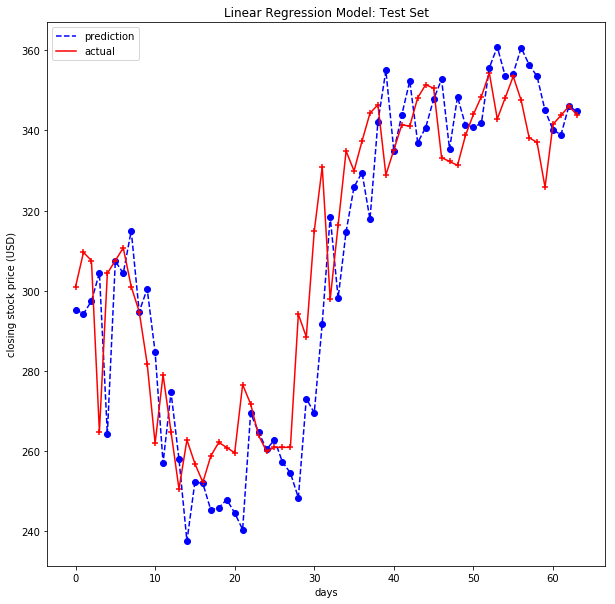

In [126]:
plt.scatter([i for i in range(len(lr_test_pred_stocks))], lr_test_pred_stocks, color='b', marker='o')
plt.scatter([i for i in range(len(test_actual_stocks))], test_actual_stocks, color='r', marker='+')
plt.plot([i for i in range(len(lr_test_pred_stocks))], lr_test_pred_stocks, color='b', linestyle='--', label='prediction')
plt.plot([i for i in range(len(test_actual_stocks))], test_actual_stocks, color='r', linestyle='-', label='actual')
plt.legend(loc='upper left')
plt.title('Linear Regression Model: Test Set')
plt.xlabel('days')
plt.ylabel('closing stock price (USD)')
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot()

### RNN
Our second model to build is an RNN.

#### Hyperparameters (rnn)
Below is a set of hyperparameters to tune for the RNN model.

In [127]:
RNN_BATCH_SIZE = 10
RNN_EPOCHS = 250
LAYERS = [
    LSTM(units=11, activation='tanh', input_shape=(M, len(features))),
    Dense(units=1, activation='linear')
] #make sure the last layer outputs dimension of 3
RNN_OPTIMIZER = SGD(lr=0.02)
RNN_LOSS = "mean_squared_error"

#### Validation (rnn)
Since our data contains time series, we will use forward chaining/nested cross-validation to validate our model. Our goal is to make average validation error small by tuning hyperparameters and modifying features. Then we can go on to train our model on the entire training set.

Note, takes about 5 minutes to run.

In [128]:
NUM_SPLITS = 5 #change splits here
tss = TimeSeriesSplit(NUM_SPLITS)

rnn_avg_val_err = 0
for subtrain_indices, val_indices in tss.split(timeseries_dataPHI_train):
    subtrain_dataPHI = timeseries_dataPHI_train[subtrain_indices[0]:subtrain_indices[len(subtrain_indices) - 1]]
    subtrain_dataY = dataY_train[subtrain_indices[0]:subtrain_indices[len(subtrain_indices) - 1]]
    val_dataPHI = timeseries_dataPHI_train[val_indices[0]:val_indices[len(val_indices) - 1]]
    val_dataY = dataY_train[val_indices[0]:val_indices[len(val_indices) - 1]]
    
    rnn = Sequential()
    for layer in LAYERS: rnn.add(layer)
    rnn.compile(loss=RNN_LOSS, optimizer=RNN_OPTIMIZER)
    rnn.fit(x=subtrain_dataPHI.reshape(len(subtrain_dataPHI), M, len(features)), y=subtrain_dataY, batch_size=RNN_BATCH_SIZE, epochs=RNN_EPOCHS, verbose=1)    
    val_pred_stocks = rnn.predict(val_dataPHI.reshape(len(val_dataPHI), M, len(features)))[:,0]
    val_actual_stocks = val_dataY
    
    rnn_avg_val_err += math.sqrt(mean_squared_error(val_pred_stocks, val_actual_stocks))
    
rnn_avg_val_err /= NUM_SPLITS
print("The average validation error for the RNN is {}".format(rnn_avg_val_err))

Epoch 1/250
45/45 [==============================] - 6s 128ms/step - loss: 70573.7326
Epoch 2/250
45/45 [==============================] - 0s 3ms/step - loss: 3773.6457
Epoch 3/250
45/45 [==============================] - 0s 3ms/step - loss: 260.4199
Epoch 4/250
45/45 [==============================] - 0s 3ms/step - loss: 123.4228
Epoch 5/250
45/45 [==============================] - 0s 3ms/step - loss: 117.1214
Epoch 6/250
45/45 [==============================] - 0s 3ms/step - loss: 121.2038
Epoch 7/250
45/45 [==============================] - 0s 3ms/step - loss: 122.4768
Epoch 8/250
45/45 [==============================] - 0s 3ms/step - loss: 118.8454
Epoch 9/250
45/45 [==============================] - 0s 3ms/step - loss: 120.4041
Epoch 10/250
45/45 [==============================] - 0s 3ms/step - loss: 121.6385
Epoch 11/250
45/45 [==============================] - 0s 3ms/step - loss: 120.1374
Epoch 12/250
45/45 [==============================] - 0s 3ms/step - loss: 117.8366
Epoch 13

45/45 [==============================] - 0s 3ms/step - loss: 119.2502
Epoch 100/250
45/45 [==============================] - 0s 3ms/step - loss: 118.6105
Epoch 101/250
45/45 [==============================] - 0s 3ms/step - loss: 117.5551
Epoch 102/250
45/45 [==============================] - 0s 3ms/step - loss: 118.7131
Epoch 103/250
45/45 [==============================] - 0s 3ms/step - loss: 116.9760
Epoch 104/250
45/45 [==============================] - 0s 3ms/step - loss: 118.2722
Epoch 105/250
45/45 [==============================] - 0s 3ms/step - loss: 118.4474
Epoch 106/250
45/45 [==============================] - 0s 3ms/step - loss: 121.3555
Epoch 107/250
45/45 [==============================] - 0s 3ms/step - loss: 118.5339
Epoch 108/250
45/45 [==============================] - 0s 3ms/step - loss: 119.1057
Epoch 109/250
45/45 [==============================] - 0s 3ms/step - loss: 120.7116
Epoch 110/250
45/45 [==============================] - 0s 3ms/step - loss: 120.1664
Epoch 

45/45 [==============================] - 0s 3ms/step - loss: 119.2730
Epoch 197/250
45/45 [==============================] - 0s 3ms/step - loss: 118.2888
Epoch 198/250
45/45 [==============================] - 0s 3ms/step - loss: 118.5122
Epoch 199/250
45/45 [==============================] - 0s 3ms/step - loss: 117.2521
Epoch 200/250
45/45 [==============================] - 0s 3ms/step - loss: 120.8583
Epoch 201/250
45/45 [==============================] - 0s 3ms/step - loss: 117.9832
Epoch 202/250
45/45 [==============================] - 0s 3ms/step - loss: 118.2622
Epoch 203/250
45/45 [==============================] - 0s 3ms/step - loss: 119.9148
Epoch 204/250
45/45 [==============================] - 0s 3ms/step - loss: 117.9124
Epoch 205/250
45/45 [==============================] - 0s 3ms/step - loss: 118.6356
Epoch 206/250
45/45 [==============================] - 0s 3ms/step - loss: 122.5913
Epoch 207/250
45/45 [==============================] - 0s 3ms/step - loss: 117.3789
Epoch 

87/87 [==============================] - 0s 3ms/step - loss: 375.5592
Epoch 45/250
87/87 [==============================] - 0s 3ms/step - loss: 365.5394
Epoch 46/250
87/87 [==============================] - 0s 3ms/step - loss: 383.9353
Epoch 47/250
87/87 [==============================] - 0s 3ms/step - loss: 368.8519
Epoch 48/250
87/87 [==============================] - 0s 3ms/step - loss: 360.3270
Epoch 49/250
87/87 [==============================] - 0s 2ms/step - loss: 361.8741
Epoch 50/250
87/87 [==============================] - 0s 3ms/step - loss: 354.2394
Epoch 51/250
87/87 [==============================] - 0s 3ms/step - loss: 360.5818
Epoch 52/250
87/87 [==============================] - 0s 3ms/step - loss: 356.2862
Epoch 53/250
87/87 [==============================] - 0s 3ms/step - loss: 357.8238
Epoch 54/250
87/87 [==============================] - 0s 3ms/step - loss: 358.1791
Epoch 55/250
87/87 [==============================] - 0s 3ms/step - loss: 348.4530
Epoch 56/250
87/8

87/87 [==============================] - 0s 2ms/step - loss: 246.6450
Epoch 143/250
87/87 [==============================] - 0s 2ms/step - loss: 239.6828
Epoch 144/250
87/87 [==============================] - 0s 2ms/step - loss: 238.9436
Epoch 145/250
87/87 [==============================] - 0s 2ms/step - loss: 243.5167
Epoch 146/250
87/87 [==============================] - 0s 2ms/step - loss: 239.1571
Epoch 147/250
87/87 [==============================] - 0s 2ms/step - loss: 237.7448
Epoch 148/250
87/87 [==============================] - 0s 2ms/step - loss: 235.5706
Epoch 149/250
87/87 [==============================] - 0s 2ms/step - loss: 239.5110
Epoch 150/250
87/87 [==============================] - 0s 2ms/step - loss: 237.9807
Epoch 151/250
87/87 [==============================] - 0s 2ms/step - loss: 237.4140
Epoch 152/250
87/87 [==============================] - 0s 2ms/step - loss: 230.7825
Epoch 153/250
87/87 [==============================] - 0s 2ms/step - loss: 229.4776
Epoch 

87/87 [==============================] - 0s 2ms/step - loss: 117.6801
Epoch 240/250
87/87 [==============================] - 0s 2ms/step - loss: 116.0507
Epoch 241/250
87/87 [==============================] - 0s 2ms/step - loss: 115.4390
Epoch 242/250
87/87 [==============================] - 0s 2ms/step - loss: 115.0504
Epoch 243/250
87/87 [==============================] - 0s 2ms/step - loss: 115.0036
Epoch 244/250
87/87 [==============================] - 0s 2ms/step - loss: 113.8163
Epoch 245/250
87/87 [==============================] - 0s 2ms/step - loss: 114.3581
Epoch 246/250
87/87 [==============================] - 0s 2ms/step - loss: 113.3951
Epoch 247/250
87/87 [==============================] - 0s 2ms/step - loss: 112.4908
Epoch 248/250
87/87 [==============================] - 0s 3ms/step - loss: 112.2109
Epoch 249/250
87/87 [==============================] - 0s 2ms/step - loss: 111.8728
Epoch 250/250
87/87 [==============================] - 0s 3ms/step - loss: 112.0472
Epoch 

129/129 [==============================] - 0s 2ms/step - loss: 78.8132
Epoch 87/250
129/129 [==============================] - 0s 2ms/step - loss: 79.9453
Epoch 88/250
129/129 [==============================] - 0s 2ms/step - loss: 78.1176
Epoch 89/250
129/129 [==============================] - 0s 2ms/step - loss: 81.7230
Epoch 90/250
129/129 [==============================] - 0s 2ms/step - loss: 78.5002
Epoch 91/250
129/129 [==============================] - 0s 3ms/step - loss: 79.8745
Epoch 92/250
129/129 [==============================] - 0s 2ms/step - loss: 80.7370
Epoch 93/250
129/129 [==============================] - 0s 3ms/step - loss: 80.8592
Epoch 94/250
129/129 [==============================] - 0s 2ms/step - loss: 80.8672
Epoch 95/250
129/129 [==============================] - 0s 3ms/step - loss: 80.7824
Epoch 96/250
129/129 [==============================] - 0s 3ms/step - loss: 80.2756
Epoch 97/250
129/129 [==============================] - 0s 3ms/step - loss: 79.1331
Epoch

129/129 [==============================] - 0s 2ms/step - loss: 73.7618
Epoch 183/250
129/129 [==============================] - 0s 2ms/step - loss: 73.4356
Epoch 184/250
129/129 [==============================] - 0s 2ms/step - loss: 75.1599
Epoch 185/250
129/129 [==============================] - 0s 2ms/step - loss: 74.2182
Epoch 186/250
129/129 [==============================] - 0s 2ms/step - loss: 73.5460
Epoch 187/250
129/129 [==============================] - 0s 2ms/step - loss: 73.3085
Epoch 188/250
129/129 [==============================] - 0s 2ms/step - loss: 73.3413
Epoch 189/250
129/129 [==============================] - 0s 2ms/step - loss: 74.1609
Epoch 190/250
129/129 [==============================] - 0s 2ms/step - loss: 73.0610
Epoch 191/250
129/129 [==============================] - 0s 2ms/step - loss: 75.2413
Epoch 192/250
129/129 [==============================] - 0s 2ms/step - loss: 78.6285
Epoch 193/250
129/129 [==============================] - 0s 2ms/step - loss: 74

171/171 [==============================] - 0s 2ms/step - loss: 186.8339
Epoch 29/250
171/171 [==============================] - 0s 2ms/step - loss: 182.6796
Epoch 30/250
171/171 [==============================] - 0s 2ms/step - loss: 178.7657
Epoch 31/250
171/171 [==============================] - 0s 2ms/step - loss: 174.1771
Epoch 32/250
171/171 [==============================] - 0s 2ms/step - loss: 168.4535
Epoch 33/250
171/171 [==============================] - 0s 2ms/step - loss: 168.8715
Epoch 34/250
171/171 [==============================] - 0s 2ms/step - loss: 163.9511
Epoch 35/250
171/171 [==============================] - 0s 2ms/step - loss: 160.5294
Epoch 36/250
171/171 [==============================] - 0s 2ms/step - loss: 166.7257
Epoch 37/250
171/171 [==============================] - 0s 2ms/step - loss: 162.1663
Epoch 38/250
171/171 [==============================] - 0s 2ms/step - loss: 171.2338
Epoch 39/250
171/171 [==============================] - 0s 2ms/step - loss: 17

171/171 [==============================] - 0s 3ms/step - loss: 106.5479
Epoch 125/250
171/171 [==============================] - 0s 2ms/step - loss: 110.3476
Epoch 126/250
171/171 [==============================] - 0s 2ms/step - loss: 105.4841
Epoch 127/250
171/171 [==============================] - 0s 2ms/step - loss: 112.9388
Epoch 128/250
171/171 [==============================] - 0s 2ms/step - loss: 111.8871
Epoch 129/250
171/171 [==============================] - 0s 2ms/step - loss: 111.9757
Epoch 130/250
171/171 [==============================] - 0s 2ms/step - loss: 107.6377
Epoch 131/250
171/171 [==============================] - 0s 2ms/step - loss: 105.9064
Epoch 132/250
171/171 [==============================] - 0s 2ms/step - loss: 105.3623
Epoch 133/250
171/171 [==============================] - 0s 2ms/step - loss: 105.5356
Epoch 134/250
171/171 [==============================] - 0s 2ms/step - loss: 104.1569
Epoch 135/250
171/171 [==============================] - 0s 2ms/step

171/171 [==============================] - 0s 2ms/step - loss: 220.9266
Epoch 220/250
171/171 [==============================] - 0s 2ms/step - loss: 217.3959
Epoch 221/250
171/171 [==============================] - 0s 2ms/step - loss: 208.4525
Epoch 222/250
171/171 [==============================] - 0s 2ms/step - loss: 200.3414
Epoch 223/250
171/171 [==============================] - 0s 2ms/step - loss: 183.9684
Epoch 224/250
171/171 [==============================] - 0s 2ms/step - loss: 177.5306
Epoch 225/250
171/171 [==============================] - 0s 2ms/step - loss: 192.5971
Epoch 226/250
171/171 [==============================] - 0s 2ms/step - loss: 174.8983
Epoch 227/250
171/171 [==============================] - 0s 2ms/step - loss: 174.3518
Epoch 228/250
171/171 [==============================] - 0s 2ms/step - loss: 169.3561
Epoch 229/250
171/171 [==============================] - 0s 2ms/step - loss: 166.6349
Epoch 230/250
171/171 [==============================] - 0s 2ms/step

213/213 [==============================] - 1s 2ms/step - loss: 216.9375
Epoch 66/250
213/213 [==============================] - 1s 2ms/step - loss: 217.3845
Epoch 67/250
213/213 [==============================] - 1s 2ms/step - loss: 217.7752
Epoch 68/250
213/213 [==============================] - 0s 2ms/step - loss: 221.7676
Epoch 69/250
213/213 [==============================] - 1s 2ms/step - loss: 216.0674
Epoch 70/250
213/213 [==============================] - 1s 3ms/step - loss: 216.6500
Epoch 71/250
213/213 [==============================] - 1s 2ms/step - loss: 217.6907
Epoch 72/250
213/213 [==============================] - 0s 2ms/step - loss: 218.5462
Epoch 73/250
213/213 [==============================] - 1s 3ms/step - loss: 217.7728
Epoch 74/250
213/213 [==============================] - 1s 3ms/step - loss: 215.5641
Epoch 75/250
213/213 [==============================] - 1s 3ms/step - loss: 215.1012
Epoch 76/250
213/213 [==============================] - 1s 2ms/step - loss: 21

213/213 [==============================] - 1s 3ms/step - loss: 204.9648
Epoch 161/250
213/213 [==============================] - 1s 3ms/step - loss: 206.3602
Epoch 162/250
213/213 [==============================] - 1s 3ms/step - loss: 202.2310
Epoch 163/250
213/213 [==============================] - 1s 3ms/step - loss: 205.2565
Epoch 164/250
213/213 [==============================] - 1s 2ms/step - loss: 203.6363
Epoch 165/250
213/213 [==============================] - 1s 2ms/step - loss: 207.1247
Epoch 166/250
213/213 [==============================] - 1s 2ms/step - loss: 204.0758
Epoch 167/250
213/213 [==============================] - 1s 3ms/step - loss: 201.7482
Epoch 168/250
213/213 [==============================] - 1s 3ms/step - loss: 205.8536
Epoch 169/250
213/213 [==============================] - 1s 3ms/step - loss: 207.2418
Epoch 170/250
213/213 [==============================] - 1s 3ms/step - loss: 204.0115
Epoch 171/250
213/213 [==============================] - 1s 3ms/step

#### Implementation/Training on Entire Train Set (rnn)
Now that we have tuned our hyperparameters, we will train on the entire training set. 

In [129]:
rnn = Sequential()
for layer in LAYERS: rnn.add(layer)
rnn.compile(loss=RNN_LOSS, optimizer=RNN_OPTIMIZER)
rnn.fit(x=timeseries_dataPHI_train.reshape(len(timeseries_dataPHI_train), M, len(features)), y=dataY_train, batch_size=RNN_BATCH_SIZE, epochs=RNN_EPOCHS, verbose=1)

Epoch 1/250
256/256 [==============================] - 7s 27ms/step - loss: 190.1826
Epoch 2/250
256/256 [==============================] - 1s 2ms/step - loss: 189.6008
Epoch 3/250
256/256 [==============================] - 1s 2ms/step - loss: 189.8647
Epoch 4/250
256/256 [==============================] - 1s 2ms/step - loss: 189.5561
Epoch 5/250
256/256 [==============================] - 1s 3ms/step - loss: 188.8714
Epoch 6/250
256/256 [==============================] - 1s 2ms/step - loss: 187.6052
Epoch 7/250
256/256 [==============================] - 1s 2ms/step - loss: 188.8735
Epoch 8/250
256/256 [==============================] - 1s 2ms/step - loss: 187.6727
Epoch 9/250
256/256 [==============================] - 1s 2ms/step - loss: 187.1138
Epoch 10/250
256/256 [==============================] - 1s 3ms/step - loss: 186.9711
Epoch 11/250
256/256 [==============================] - 1s 3ms/step - loss: 188.1825
Epoch 12/250
256/256 [==============================] - 1s 3ms/step - los

256/256 [==============================] - 1s 2ms/step - loss: 175.7426
Epoch 98/250
256/256 [==============================] - 1s 2ms/step - loss: 175.1164
Epoch 99/250
256/256 [==============================] - 1s 2ms/step - loss: 172.7811
Epoch 100/250
256/256 [==============================] - 1s 2ms/step - loss: 173.5892
Epoch 101/250
256/256 [==============================] - 1s 2ms/step - loss: 179.6022
Epoch 102/250
256/256 [==============================] - 1s 2ms/step - loss: 180.0433
Epoch 103/250
256/256 [==============================] - 1s 2ms/step - loss: 175.3795
Epoch 104/250
256/256 [==============================] - 1s 2ms/step - loss: 176.6606
Epoch 105/250
256/256 [==============================] - 1s 2ms/step - loss: 176.0001
Epoch 106/250
256/256 [==============================] - 1s 2ms/step - loss: 175.8340
Epoch 107/250
256/256 [==============================] - 1s 2ms/step - loss: 176.1521
Epoch 108/250
256/256 [==============================] - 1s 2ms/step -

256/256 [==============================] - 1s 2ms/step - loss: 165.6500
Epoch 193/250
256/256 [==============================] - 1s 2ms/step - loss: 166.6534
Epoch 194/250
256/256 [==============================] - 1s 2ms/step - loss: 171.4599
Epoch 195/250
256/256 [==============================] - 1s 2ms/step - loss: 166.0292
Epoch 196/250
256/256 [==============================] - 1s 2ms/step - loss: 168.0490
Epoch 197/250
256/256 [==============================] - 1s 2ms/step - loss: 167.6629
Epoch 198/250
256/256 [==============================] - 1s 2ms/step - loss: 165.1496
Epoch 199/250
256/256 [==============================] - 1s 2ms/step - loss: 168.0261
Epoch 200/250
256/256 [==============================] - 1s 2ms/step - loss: 166.4671
Epoch 201/250
256/256 [==============================] - 1s 2ms/step - loss: 166.9683
Epoch 202/250
256/256 [==============================] - 1s 2ms/step - loss: 168.1239
Epoch 203/250
256/256 [==============================] - 1s 2ms/step

#### Error Analysis (rnn)
Below we will conduct some error analysis on our model. We will compare average training errors and average test errors to see if our model is generalized. 

In [130]:
train_actual_stocks = dataY_train
test_actual_stocks = dataY_test

rnn_train_pred_stocks = rnn.predict(timeseries_dataPHI_train.reshape(len(timeseries_dataPHI_train), M, len(features)))[:,0]

rnn_test_pred_stocks = rnn.predict(timeseries_dataPHI_test.reshape(len(timeseries_dataPHI_test), M, len(features)))[:,0]
    
rnn_avg_train_err = math.sqrt(mean_squared_error(rnn_train_pred_stocks, train_actual_stocks))
rnn_avg_test_err = math.sqrt(mean_squared_error(rnn_test_pred_stocks, test_actual_stocks))

print("Average train error for the RNN was {}.".format(rnn_avg_train_err))
print("Average test error for the RNN was {}.".format(rnn_avg_test_err))

Average train error for the RNN was 13.245984488735568.
Average test error for the RNN was 20.507009762901024.


In [131]:
rnn_train_accuracy = 0
for i in range(1, len(train_actual_stocks)):
    if((rnn_train_pred_stocks[i] > train_actual_stocks[i-1] and train_actual_stocks[i] > train_actual_stocks[i-1]) or
       (rnn_train_pred_stocks[i] < train_actual_stocks[i-1] and train_actual_stocks[i] < train_actual_stocks[i-1])
      ):
        rnn_train_accuracy += 1
rnn_train_accuracy /= len(train_actual_stocks)

rnn_test_accuracy = 0
for i in range(1, len(test_actual_stocks)):
    if((rnn_test_pred_stocks[i] > test_actual_stocks[i-1] and test_actual_stocks[i] > test_actual_stocks[i-1]) or
       (rnn_test_pred_stocks[i] < test_actual_stocks[i-1] and test_actual_stocks[i] < test_actual_stocks[i-1])
      ):
        rnn_test_accuracy += 1
rnn_test_accuracy /= len(test_actual_stocks)

print("Average trend train accuracy for the RNN was {}.".format(rnn_train_accuracy))
print("Average trend test accuracy for the RNN was {}.".format(rnn_test_accuracy))

Average trend train accuracy for the RNN was 0.56640625.
Average trend test accuracy for the RNN was 0.53125.


#### Graphing Results (rnn)
We will now graph our results for both our training and testing data. Ideally we would like all our predictions to fall on the blue line. 

[]

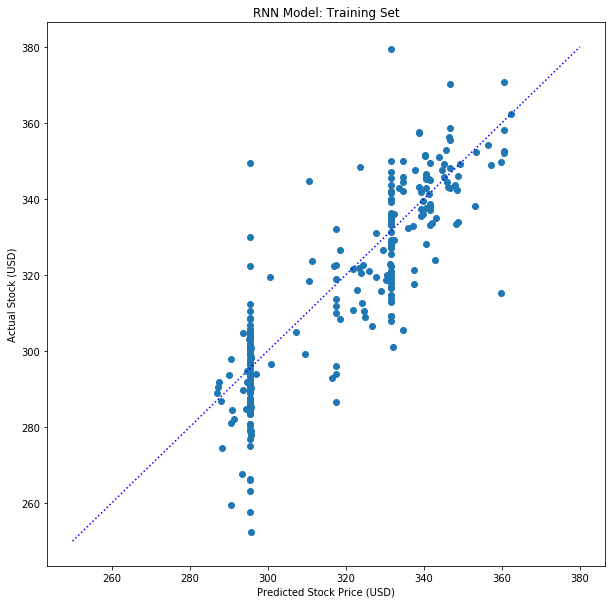

In [132]:
plt.scatter(rnn_train_pred_stocks, train_actual_stocks)
plt.plot([250, 380], [250, 380], linestyle=':', color='b')
plt.title('RNN Model: Training Set')
plt.xlabel('Predicted Stock Price (USD)')
plt.ylabel('Actual Stock (USD)')
plt.plot()

[]

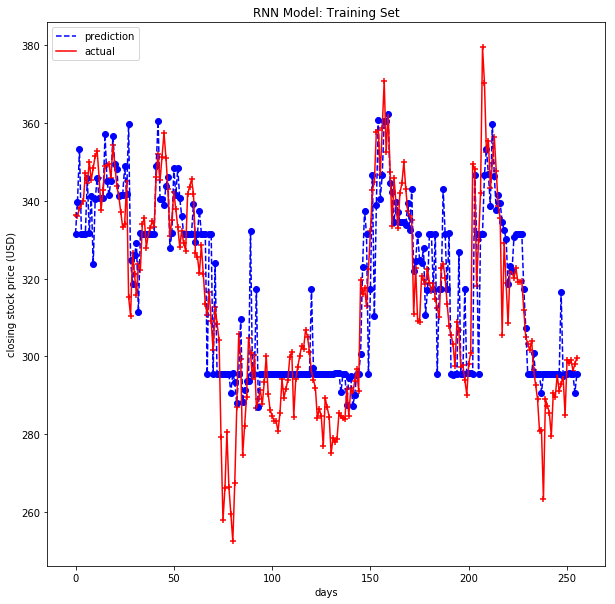

In [133]:
plt.scatter([i for i in range(len(train_actual_stocks))], train_actual_stocks, color='r', marker='+')
plt.scatter([i for i in range(len(rnn_train_pred_stocks))], rnn_train_pred_stocks, color='b', marker='o')
plt.plot([i for i in range(len(rnn_train_pred_stocks))], rnn_train_pred_stocks, color='b', linestyle='--', label='prediction')
plt.plot([i for i in range(len(train_actual_stocks))], train_actual_stocks, color='r', linestyle='-', label='actual')

plt.legend(loc='upper left')
plt.title('RNN Model: Training Set')
plt.xlabel('days')
plt.ylabel('closing stock price (USD)')
plt.plot()

[]

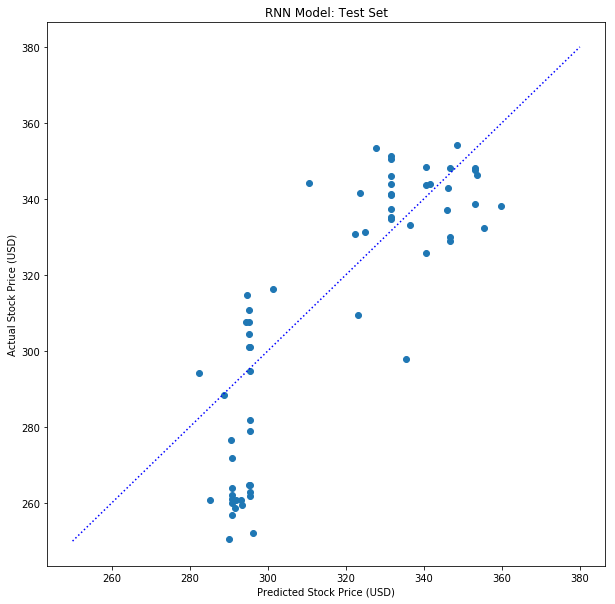

In [134]:
plt.scatter(rnn_test_pred_stocks, test_actual_stocks)
plt.plot([250, 380], [250, 380], color='b', linestyle=':')
plt.title('RNN Model: Test Set')
plt.xlabel('Predicted Stock Price (USD)')
plt.ylabel('Actual Stock Price (USD)')
plt.plot()

[]

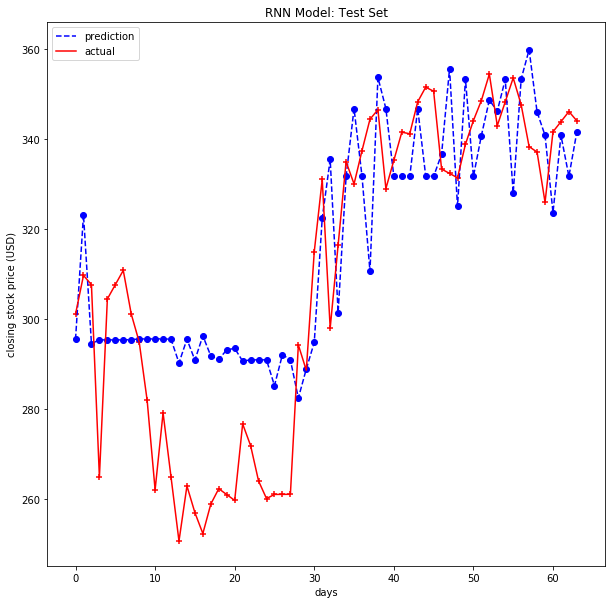

In [135]:
plt.scatter([i for i in range(len(test_actual_stocks))], test_actual_stocks, color='r', marker='+')
plt.scatter([i for i in range(len(rnn_test_pred_stocks))], rnn_test_pred_stocks, color='b', marker='o')
plt.plot([i for i in range(len(rnn_test_pred_stocks))], rnn_test_pred_stocks, color='b', linestyle='--', label='prediction')
plt.plot([i for i in range(len(test_actual_stocks))], test_actual_stocks, color='r', linestyle='-', label='actual')

plt.legend(loc='upper left')
plt.title('RNN Model: Test Set')
plt.xlabel('days')
plt.ylabel('closing stock price (USD)')
plt.plot()